In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Thu Jan 11 22:07:45 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   26C    P8    13W / 230W |      6MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_min_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-11/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 78052
-rw-rw-r-- 1 scpark scpark  1084580  1월 11 22:07 events.out.tfevents.1704978080.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37979741  1월 11 22:06 save_10000
-rw-rw-r-- 1 scpark scpark 37973949  1월 11 22:01 save_0
-rw-rw-r-- 1 scpark scpark  1148132  1월 11 22:01 events.out.tfevents.1704977493.GPUSVR01
-rw-rw-r-- 1 scpark scpark   957188  1월 11 21:51 events.out.tfevents.1704977008.GPUSVR01
-rw-rw-r-- 1 scpark scpark   772580  1월 11 21:43 events.out.tfevents.1704976601.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=8, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


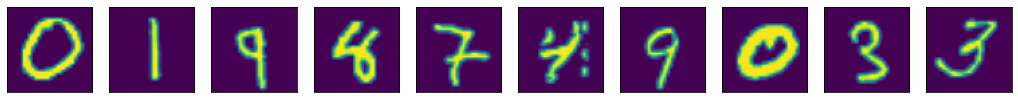

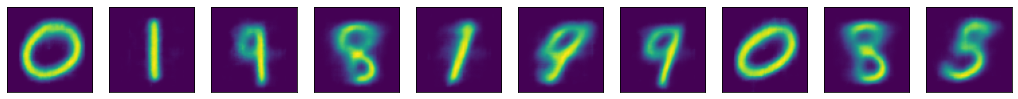

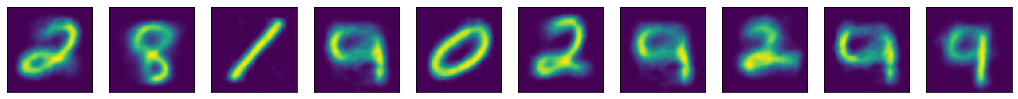

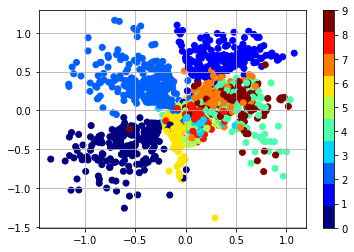

33001
lse_loss 0.00016948496340774
recon_loss 0.09923058748245239
33002
lse_loss 0.00014242104953154922
recon_loss 0.14302703738212585
33003
lse_loss 9.220969513989985e-05
recon_loss 0.1206519603729248
33004
lse_loss 0.00010141139500774443
recon_loss 0.11505694687366486
33005
lse_loss 0.0001554757618578151
recon_loss 0.09453409910202026
33006
lse_loss 9.967546793632209e-05
recon_loss 0.11029303073883057
33007
lse_loss 0.00012178733595646918
recon_loss 0.12297394126653671
33008
lse_loss 0.0001486996334278956
recon_loss 0.14685353636741638
33009
lse_loss 0.00027708272682502866
recon_loss 0.13564060628414154
33010
lse_loss 5.923393473494798e-05
recon_loss 0.08381092548370361
33011
lse_loss 4.346141577116214e-05
recon_loss 0.1221214085817337
33012
lse_loss 7.801453466527164e-05
recon_loss 0.10561122745275497
33013
lse_loss 0.00010727143671829253
recon_loss 0.14203321933746338
33014
lse_loss 0.00010158457735087723
recon_loss 0.13842789828777313
33015
lse_loss 0.00019398899166844785
recon_lo

lse_loss 0.0005916908849030733
recon_loss 0.09715181589126587
33129
lse_loss 8.159552089637145e-05
recon_loss 0.09037630259990692
33130
lse_loss 0.00015616999007761478
recon_loss 0.1354079246520996
33131
lse_loss 0.00015031537623144686
recon_loss 0.158594012260437
33132
lse_loss 0.00013890278933104128
recon_loss 0.17743824422359467
33133
lse_loss 0.00013886087981518358
recon_loss 0.16506129503250122
33134
lse_loss 0.00014495078357867897
recon_loss 0.1390204280614853
33135
lse_loss 0.0001607104204595089
recon_loss 0.1117178201675415
33136
lse_loss 3.9486832974944264e-05
recon_loss 0.1251770704984665
33137
lse_loss 6.855893298052251e-05
recon_loss 0.11413180828094482
33138
lse_loss 0.00047176473890431225
recon_loss 0.11661209166049957
33139
lse_loss 0.0009055030532181263
recon_loss 0.1035095751285553
33140
lse_loss 0.00015698395145591348
recon_loss 0.14878180623054504
33141
lse_loss 0.0001813494454836473
recon_loss 0.1306914985179901
33142
lse_loss 0.0005055638030171394
recon_loss 0.1127

33255
lse_loss 0.00014487846055999398
recon_loss 0.11547140777111053
33256
lse_loss 0.00011395498586352915
recon_loss 0.1384401172399521
33257
lse_loss 0.0001716482947813347
recon_loss 0.11120899021625519
33258
lse_loss 0.00013581560051534325
recon_loss 0.11185991019010544
33259
lse_loss 6.338361708912998e-05
recon_loss 0.12720762193202972
33260
lse_loss 0.00015133156557567418
recon_loss 0.08580994606018066
33261
lse_loss 9.525616769678891e-05
recon_loss 0.1373513787984848
33262
lse_loss 9.969658276531845e-05
recon_loss 0.1467355191707611
33263
lse_loss 9.391420462634414e-05
recon_loss 0.13147294521331787
33264
lse_loss 3.3276097383350134e-05
recon_loss 0.11268573999404907
33265
lse_loss 0.00015940114099066705
recon_loss 0.15836064517498016
33266
lse_loss 0.00012689660070464015
recon_loss 0.13568703830242157
33267
lse_loss 0.00010041979840025306
recon_loss 0.13208158314228058
33268
lse_loss 0.00015505208284594119
recon_loss 0.09202011674642563
33269
lse_loss 8.971343049779534e-05
recon

33381
lse_loss 0.00013914388546254486
recon_loss 0.16030484437942505
33382
lse_loss 0.00015352059563156217
recon_loss 0.1168719157576561
33383
lse_loss 0.00014925395953468978
recon_loss 0.1314500868320465
33384
lse_loss 0.00015098010771907866
recon_loss 0.11870276927947998
33385
lse_loss 0.00012216012692078948
recon_loss 0.14219650626182556
33386
lse_loss 9.464378672419116e-05
recon_loss 0.14276842772960663
33387
lse_loss 0.00011815548350568861
recon_loss 0.12435129284858704
33388
lse_loss 0.00014497119991574436
recon_loss 0.10104808211326599
33389
lse_loss 0.0001092634629458189
recon_loss 0.1055445522069931
33390
lse_loss 0.00010866954835364595
recon_loss 0.1249854564666748
33391
lse_loss 0.00023895141202956438
recon_loss 0.1294461190700531
33392
lse_loss 0.00020981165289413184
recon_loss 0.14385992288589478
33393
lse_loss 8.574724779464304e-05
recon_loss 0.12373661249876022
33394
lse_loss 0.00013047599350102246
recon_loss 0.11020287871360779
33395
lse_loss 0.0001604256103746593
recon

33509
lse_loss 0.000162661584909074
recon_loss 0.11369998753070831
33510
lse_loss 0.00011674581037368625
recon_loss 0.11515965312719345
33511
lse_loss 8.353327575605363e-05
recon_loss 0.12161528319120407
33512
lse_loss 0.00016100640641525388
recon_loss 0.11822733283042908
33513
lse_loss 0.00010749504144769162
recon_loss 0.08568581938743591
33514
lse_loss 6.0545309679582715e-05
recon_loss 0.1487964242696762
33515
lse_loss 8.707913366379216e-05
recon_loss 0.11109571158885956
33516
lse_loss 9.991054685087875e-05
recon_loss 0.11807908862829208
33517
lse_loss 6.961021426832303e-05
recon_loss 0.0832640677690506
33518
lse_loss 7.171630568336695e-05
recon_loss 0.09313754737377167
33519
lse_loss 0.00011458596418378875
recon_loss 0.12797141075134277
33520
lse_loss 0.0002796957269310951
recon_loss 0.13480797410011292
33521
lse_loss 0.00010364434274379164
recon_loss 0.1771923303604126
33522
lse_loss 0.00014841818483546376
recon_loss 0.1345025599002838
33523
lse_loss 0.00011452037142589688
recon_lo

lse_loss 0.00011161781003465876
recon_loss 0.09833618253469467
33631
lse_loss 0.000963671482168138
recon_loss 0.12526318430900574
33632
lse_loss 0.001841842196881771
recon_loss 0.11288376897573471
33633
lse_loss 0.0001876478490885347
recon_loss 0.12215267866849899
33634
lse_loss 0.00014136020035948604
recon_loss 0.1070631891489029
33635
lse_loss 0.00019811917445622385
recon_loss 0.12373560667037964
33636
lse_loss 0.00011450968304416165
recon_loss 0.11602755635976791
33637
lse_loss 0.00022876414004713297
recon_loss 0.1492418795824051
33638
lse_loss 8.086014713626355e-05
recon_loss 0.11788766086101532
33639
lse_loss 0.00015877833357080817
recon_loss 0.10719871520996094
33640
lse_loss 0.0001675694657023996
recon_loss 0.14606940746307373
33641
lse_loss 0.00013231739285402
recon_loss 0.09900351613759995
33642
lse_loss 0.00011001549137290567
recon_loss 0.1526317298412323
33643
lse_loss 0.00014848465798422694
recon_loss 0.09549864381551743
33644
lse_loss 0.0007213215576484799
recon_loss 0.126

33758
lse_loss 0.00014168291818350554
recon_loss 0.11793728172779083
33759
lse_loss 0.0001230298657901585
recon_loss 0.0990355834364891
33760
lse_loss 0.00021412299247458577
recon_loss 0.08595272153615952
33761
lse_loss 0.0001759589067660272
recon_loss 0.12031419575214386
33762
lse_loss 0.00018073782848659903
recon_loss 0.1255652755498886
33763
lse_loss 6.979636964388192e-05
recon_loss 0.1587514728307724
33764
lse_loss 0.00010140590165974572
recon_loss 0.17005491256713867
33765
lse_loss 8.131777576636523e-05
recon_loss 0.119861900806427
33766
lse_loss 0.0001928192505147308
recon_loss 0.1824769228696823
33767
lse_loss 7.69152247812599e-05
recon_loss 0.09367402642965317
33768
lse_loss 9.168208634946495e-05
recon_loss 0.1071939468383789
33769
lse_loss 0.0001227380707859993
recon_loss 0.15717850625514984
33770
lse_loss 0.00012694903125520796
recon_loss 0.0901828408241272
33771
lse_loss 9.14836346055381e-05
recon_loss 0.18716947734355927
33772
lse_loss 6.233179738046601e-05
recon_loss 0.124

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=10000, sigma=1e-1)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = (torch.rand(10, hp.z_dim)*2-1).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        